In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chart_studio.plotly as plotly
import plotly.graph_objects as go
from plotly.offline import iplot, plot, init_notebook_mode
from collections import defaultdict
import re
from matplotlib.dates import date2num, num2date
import warnings
warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)
plt.rc('axes', axisbelow=True)

### Summarize number of repositories

In [12]:
valid_repos = pd.read_csv("statistic/valid_repos.csv")
print("Number of valid repositories:", len(valid_repos))
has_release = pd.read_csv("statistic/has_release.csv")
has_rn = pd.read_csv("statistic/has_release_note.csv")
print("Number of repositories that has release:", len(has_release), '~', f"{round(len(has_release) / len(valid_repos) * 10000) / 100}%")
print("Number of repositories that has release note:", len(has_rn), '~', f"{round(len(has_rn) / len(valid_repos) * 10000) / 100}%")


Number of valid repositories: 3086
Number of repositories that has release: 2263 ~ 73.33%
Number of repositories that has release note: 2171 ~ 70.35%


### Relationship between repositories and release 

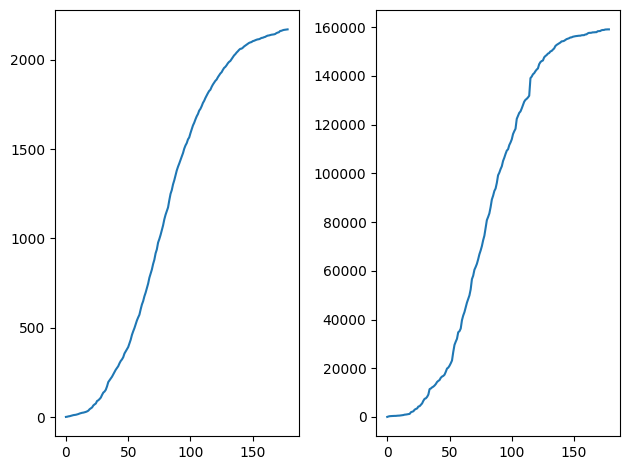

,Repo,Release Note
Repo,1.000000,0.999188
Release Note,0.999188,1.000000


In [13]:
has_rn["created_at"] = pd.to_datetime(has_rn["created_at"])
has_rn["created_month"] = has_rn["created_at"].dt.month
has_rn["created_year"] = has_rn["created_at"].dt.year
num_repo = np.cumsum(has_rn.groupby(["created_year", "created_month"])["Repo"].count().to_numpy())
num_rn = np.cumsum(has_rn.groupby(["created_year", "created_month"])["num release"].sum().to_numpy())
x = np.arange(0, len(num_repo),1)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(x, num_repo)
axes[1].plot(x, num_rn)
plt.tight_layout() 
plt.show()
df = pd.DataFrame({"Repo": num_repo, "Release Note": num_rn})
df.corr()

### Relationship repositories has release note has link

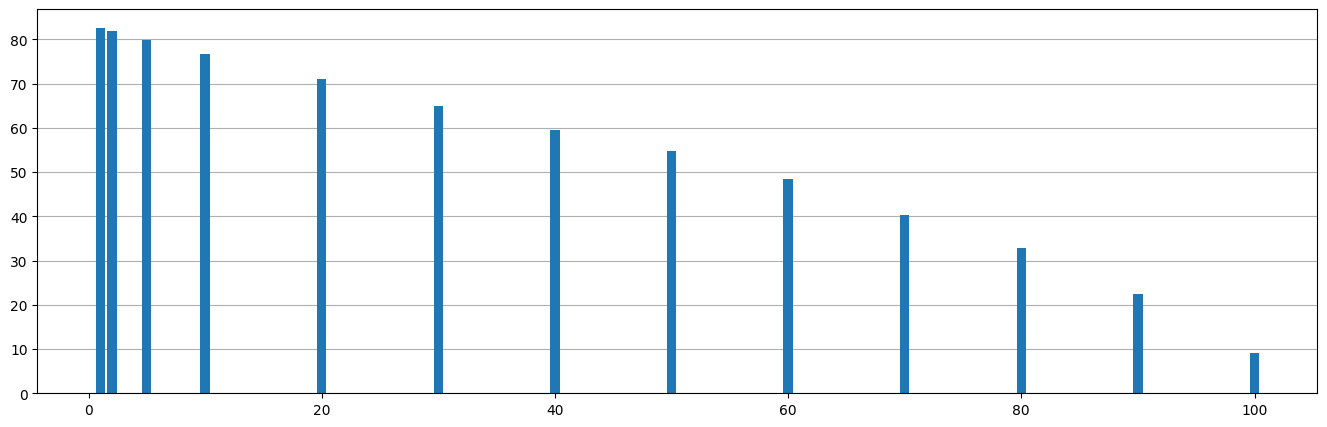

In [14]:
change_descriptor = pd.read_csv("statistic/has_change_descriptor.csv")
num_repos = len(change_descriptor)
repo_ratio = [sum(change_descriptor[ratio]) / num_repos * 100 for ratio in change_descriptor.columns[1:]]
rn_ratio = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 0.8])
axes.bar(rn_ratio, repo_ratio)
plt.grid(visible=True, axis='y')


### Relationship between release and release note

[    4     7    36    53   107   262   390  1636  4739  8569 11164 13493
 14611 16754 19761 21354 24713 21457]
[    4     5    22    44    93   225   323  1441  4021  7590  9939 12491
 13408 15461 18107 19816 23570 20457]


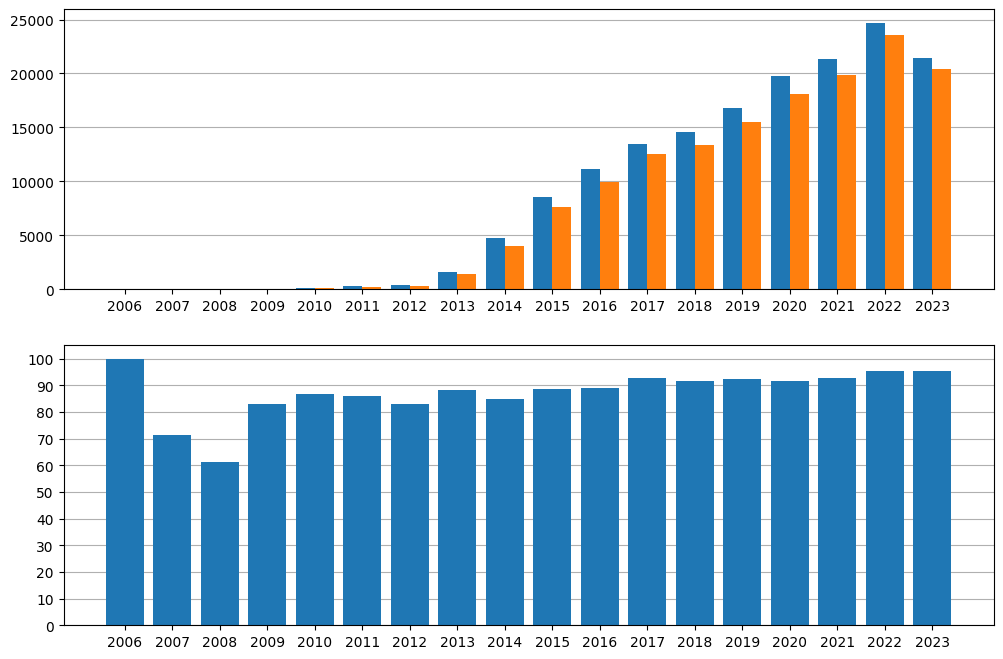

In [50]:
from statistic import filter_string
years = np.arange(2006, 2024, 1)
total_release = np.zeros(len(years), dtype=np.int64)
total_rn = np.zeros(len(years), dtype=np.int64)
for repo in has_rn["Repo"]:
    # print(repo)
    release_info = pd.read_csv(f"statistic/release/{repo.replace('/', '_')}.csv")
    release_info["created_at"] = pd.to_datetime(release_info["created_at"])
    release_info["created_year"] = release_info["created_at"].dt.year
    for i, year in enumerate(years):
        tmp = release_info[release_info["created_year"] == year]["body"]
        total_release[i] += len(tmp)
        total_rn[i] += sum([1 if not pd.isna(body) and filter_string(body) else 0 for body in tmp])
print(total_release)
print(total_rn)
fig = plt.figure(figsize=[12, 8])
axes = fig.subplots(nrows=2, ncols=1)
axes[0].bar(years, total_release, align="edge", width=-0.4)
axes[0].bar(years, total_rn, align="edge", width=0.4)
axes[0].grid(visible=True, axis='y')
axes[0].set_xticks(years)

axes[1].bar(years, total_rn / total_release * 100)
axes[1].set_yticks(np.arange(0, 110, 10))
axes[1].grid(visible=True, axis='y')
axes[1].set_xticks(years)

fig.show()



### Relationship between release note and change descriptor link

In [26]:
from statistic import filter_string, validate

has_rn = pd.read_csv("statistic/has_release_note.csv")
release_time = defaultdict(lambda: [0, 0])
for repo in has_rn["Repo"]:
    release_info = pd.read_csv(f"statistic/release/{repo.replace('/', '_')}.csv")[["body", "created_at"]]
    release_info["created_at"] = pd.to_datetime(release_info["created_at"])
    release_info["year"] = release_info["created_at"].dt.year
    for i in range(len(release_info)):
        if not pd.isna(release_info.loc[i, "body"]) and filter_string(release_info.loc[i, "body"]):
            release_time[release_info.loc[i, "year"]][0] += 1
            if validate(release_info.loc[i, "body"]):
                release_time[release_info.loc[i, "year"]][1] += 1   

result = defaultdict()
for year in release_time:
    result[year] = round(release_time[year][1] / release_time[year][0] * 10000) / 100
import plotly.express as px
df = pd.DataFrame({"Year": result.keys(), "Release note has link ratio": result.values()})
fig = px.bar(df, x="Year", y="Release note has link ratio")
fig.show()

### Time between two release distribution

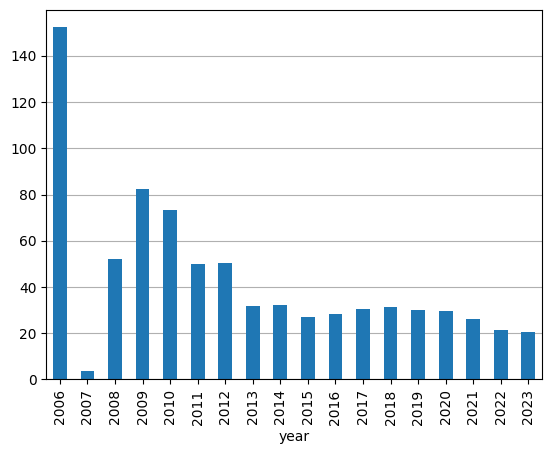

In [43]:
timebw2rn = pd.read_csv("statistic/timebw2rn.csv")
time = timebw2rn.groupby("year")["num days"].mean()
time.plot(kind="bar")
plt.grid(visible=True, axis='y')



In [44]:
timebw2rn[timebw2rn["year"] == 2007]

,Repo,tag_name,num days,year
151489,mamedev/mame,mame0122,0.711794,2007
152785,flot/flot,v0.2.0,3.855637,2007
152786,flot/flot,v0.3.0,7.064919,2007
